In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cartopy.crs as ccrs  
#import mo_pack
from matplotlib import ticker, cm
#import imageio
import iris.analysis.cartography
from iris.analysis.cartography import _meshgrid, rotate_pole, rotate_winds
from aeolus.coord import get_xy_coords
from iris.coords import AuxCoord
from iris.util import promote_aux_coord_to_dim_coord
import aeolus
from iris.coord_systems import RotatedGeogCS
from aeolus.calc.diag import lat_cos
from iris.util import reverse
from aeolus.calc.stats import cumsum, spatial
from aeolus.coord import roll_cube_pm180, volume_weights_cube, area_weights_cube, coord_delta_to_cube, interp_cube_from_height_to_pressure_levels
import matplotlib.colors as colors 
from aeolus.const import init_const
import matplotlib
pcb_const=init_const('proxb')

In [2]:
warnings.filterwarnings("ignore")


# Import the data

In [3]:
pcb_tl = iris.load('data/pcb_nox_7560_120_ste.nc')

In [4]:
def newheight(cubes, max_tslice=-1):            
    for cube in cubes:
        if cube.coords()[1].long_name=='Hybrid height':
            height_new = cube.coord('Hybrid height')
            height_new.rename('level_height')
newheight(pcb_tl)

# Functions for statistics, slicing

In [5]:

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume


def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

def height_to_pressure(cube, pressurecube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = pressurecube.interpolate(height, iris.analysis.Linear())
    rflux_reg=interp_cube_from_height_to_pressure_levels(cube, p_reg, meridional_mean(zonal_mean(p_reg)).data)
    return rflux_reg 



# Requirements for lifetime calculations

In [6]:
k_b = 1.38e-23 #J/K
g = pcb_const.gravity.data #m/s2
m_air = 28.964*(1.66e-27) #kg

In [7]:
def vmr_molec(cube, p_cube, t_cube):
    height = [('level_height', cube.coord('level_height').points)]
    p_reg = p_cube.interpolate(height, iris.analysis.Linear())
    volume = volume_weights_cube2(cube)
    nair=(p_reg*volume)/((1.38*10**(-23))*t_cube) #nair in molec/gridbox
    cube_molec = cube*nair/volume #n_o3 in molec/m3
    cube_molec *= 1e-6
    return cube_molec
def rflux_molec(cube):
    volume = volume_weights_cube2(cube)
    cube_molec = cube*(6.022e23)/volume
    return cube_molec

def dtyn_vert(zwind):##in years
    vert_height=zwind[1:].coord('level_height').points-zwind[0:60].coord('level_height').points
    tdyn_vert_inv=(zwind[1:]/vert_height)
    tdyn_vert=1/tdyn_vert_inv
    return tdyn_vert

def scale_height(temp):
    H = k_b*temp/(m_air*g)
    return H
def selected_slice_mean(cube,lat_l,lat_u,lon_range):
    cube2 = cube[:,lat_l:lat_u,lon_range]
    cube2 = zonal_mean(meridional_mean(cube2))
    return cube2

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Figure 10: chemical and dynamical lifetimes at distinct locations in planetary atmosphere

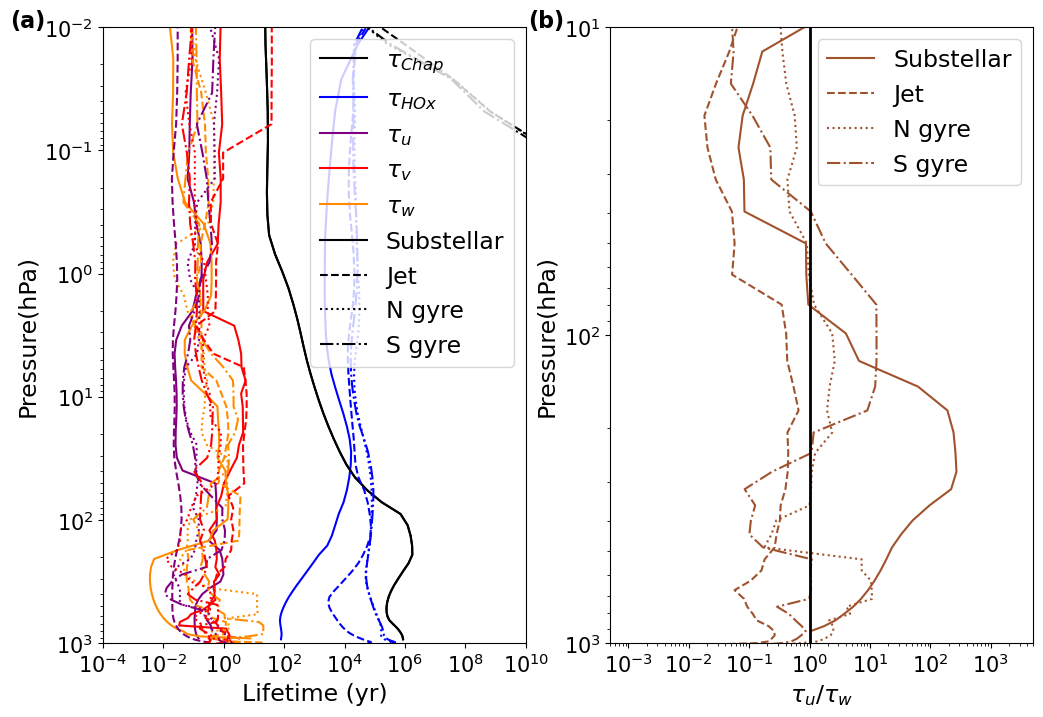

In [14]:

    
def lifetimes(cubelist, lname_mol='O3 MASS MIXING RATIO', vlevel=0, m_mol=48, time_slice_l=0,
                                              time_slice_u=120,vmin=None, vmax=None, sublabel=False, sublabel_t='a', 
                                   tl_coord=False, max_o3=2e3, const=None, save=False, model=aeolus.model.um):
    for cube in cubelist:
        if cube.standard_name == 'eastward_wind':
            u = cube[time_slice_l:time_slice_u,:,:,:].copy()
            u=u.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'northward_wind':
            v = cube[time_slice_l:time_slice_u,:,:,:].copy()
            v=v.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name == 'upward_air_velocity':
            w = cube[time_slice_l:time_slice_u,:,:,:].copy()
            w=w.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_pressure':
            pres_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_temperature':
            temp_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50120':
            rf50120 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50120=rf50120.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50013':
            rf50013 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50013=rf50013.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50118':
            rf50118 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50118=rf50118.collapsed('t', iris.analysis.MEAN)
        if cube.long_name =='Stash code = 50501':
            rf50501 = cube[time_slice_l:time_slice_u,:,:,:].copy()
            rf50501=rf50501.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == lname_mol:
            vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            vmr = vmr.collapsed('t', iris.analysis.MEAN)*29.3/m_mol
    v = v.regrid(u, iris.analysis.Linear())
    w = w.regrid(u, iris.analysis.Linear())

    height = [('level_height', v.coord('level_height').points)]
    v = v.interpolate(height, iris.analysis.Linear())
    w = w.interpolate(height, iris.analysis.Linear())
    pres_cube = pres_cube.interpolate(height, iris.analysis.Linear())
    H = scale_height(temp_cube)
    H = H.interpolate(height, iris.analysis.Linear())
    H = H.regrid(u, iris.analysis.Linear())
    tau_u = (1/u)*(1/(3600*24*365))*2*np.pi*const.radius
    tau_u = height_to_pressure(tau_u, pres_cube)
    tau_v = (1/v)*(1/(3600*24*365))*np.pi*const.radius
    tau_v = height_to_pressure(tau_v, pres_cube)
    tau_w = (1/w)*(1/(3600*24*365))*H
    tau_w = height_to_pressure(tau_w, pres_cube)    
    
    ##chemical lifetimes
    ndens = vmr_molec(vmr, pres_cube, temp_cube)
    ndens_p = height_to_pressure(ndens, pres_cube)    
    rf50120 = rflux_molec(rf50120)
    rf50120_p = height_to_pressure(rf50120, pres_cube)
    tau_chap=ndens_p/rf50120_p
    #tau_chap_day, tau_chap_night=hemisphere_sep(tau_chap)
    rf50013 = rflux_molec(rf50013)
    rf50013_p = height_to_pressure(rf50013, pres_cube)
    tau_hox1=ndens_p/rf50013_p
    rf50118 = rflux_molec(rf50118)
    rf50118_p = height_to_pressure(rf50118, pres_cube)
    tau_hox2=ndens_p/rf50118_p
    rf50501 = rflux_molec(rf50501)
    rf50501_p = height_to_pressure(rf50501, pres_cube)
    tau_3ox=ndens_p/rf50501_p
    lev_exp = np.arange(4,12,0.2)
    levs = np.power(10, lev_exp)


    ##SS point
    tau_chap_ss = selected_slice_mean(tau_chap,40,50,[0,1,2,3,140,141,142,143])
    tau_hox1_ss = selected_slice_mean(tau_hox1,40,50,[0,1,2,3,140,141,142,143])
    tau_u_ss = selected_slice_mean(tau_u,40,50,[0,1,2,3,140,141,142,143])
    tau_v_ss = selected_slice_mean(tau_v,40,50,[0,1,2,3,140,141,142,143])
    tau_w_ss = selected_slice_mean(tau_w,40,50,[0,1,2,3,140,141,142,143])
    tau_3ox_ss = selected_slice_mean(tau_3ox,40,50,[0,1,2,3,140,141,142,143])
    ##Jet
    tau_chap_j = selected_slice_mean(tau_chap,40,50,np.arange(81,88))
    tau_hox1_j = selected_slice_mean(tau_hox1,40,50,np.arange(81,88))
    tau_u_j = selected_slice_mean(tau_u,40,50,np.arange(81,88))
    tau_v_j = selected_slice_mean(tau_v,40,50,np.arange(81,88))
    tau_w_j = selected_slice_mean(tau_w,40,50,np.arange(81,88))
    tau_3ox_j = selected_slice_mean(tau_3ox,40,50,np.arange(81,88))
    ##N gyre
    tau_chap_ng = selected_slice_mean(tau_chap,72,77,np.arange(81,88))
    tau_hox1_ng = selected_slice_mean(tau_hox1,72,77,np.arange(81,88))
    tau_u_ng = selected_slice_mean(tau_u,72,77,np.arange(81,88))
    tau_v_ng = selected_slice_mean(tau_v,72,77,np.arange(81,88))
    tau_w_ng = selected_slice_mean(tau_w,72,77,np.arange(81,88))
    tau_3ox_ng = selected_slice_mean(tau_3ox,72,77,np.arange(81,88))
    ##S gyre
    tau_chap_sg = selected_slice_mean(tau_chap,13,18,np.arange(81,88))
    tau_hox1_sg = selected_slice_mean(tau_hox1,13,18,np.arange(81,88))
    tau_u_sg = selected_slice_mean(tau_u,13,18,np.arange(81,88))
    tau_v_sg = selected_slice_mean(tau_v,13,18,np.arange(81,88))
    tau_w_sg = selected_slice_mean(tau_w,13,18,np.arange(81,88))
    tau_3ox_sg = selected_slice_mean(tau_3ox,13,18,np.arange(81,88))
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(121)
    if sublabel==True:
        ax.text(-0.22,1.0, '(a)', size=16, weight='bold',transform=ax.transAxes)    
    plt.plot(smooth(tau_chap_ss.data,5), tau_chap_ss.coord("air_pressure").points/100, color='black',ls='-',label=r'$\tau_{Chap}$')
    plt.plot(smooth(tau_hox1_ss.data,5), tau_hox1_ss.coord("air_pressure").points/100, color='blue',ls='-', label=r'$\tau_{HOx}$')
    plt.plot(smooth(abs(tau_u_ss.data),5), tau_u_ss.coord("air_pressure").points/100, color='purple',ls='-', label=r'$\tau_u$')
    plt.plot(smooth(abs(tau_v_ss.data),5), tau_v_ss.coord("air_pressure").points/100, color='red', ls='-', label=r'$\tau_{v}$')
    plt.plot(smooth(abs(tau_w_ss.data),5), tau_w_ss.coord("air_pressure").points/100, color='darkorange', ls='-', label=r'$\tau_{w}$')
    plt.plot(smooth(tau_chap_ss.data,5), tau_chap_ss.coord("air_pressure").points/100, color='black', ls='-',label='Substellar')
    plt.plot(smooth(tau_chap_j.data,5), tau_chap_j.coord("air_pressure").points/100, color='black', ls='--',label='Jet')
    plt.plot(smooth(tau_chap_ng.data,5), tau_chap_ng.coord("air_pressure").points/100, color='black', ls='dotted',label='N gyre')
    plt.plot(smooth(tau_chap_sg.data,5), tau_chap_sg.coord("air_pressure").points/100, color='black', ls='dashdot',label='S gyre')
    plt.plot(smooth(tau_hox1_j.data,5), tau_hox1_j.coord("air_pressure").points/100, color='blue', ls='--')
    plt.plot(smooth(tau_hox1_ng.data,5), tau_hox1_ng.coord("air_pressure").points/100, color='blue', ls='dotted')
    plt.plot(smooth(tau_hox1_sg.data,5), tau_hox1_sg.coord("air_pressure").points/100, color='blue', ls='dashdot')
    plt.plot(smooth(abs(tau_w_j.data),5), tau_w_j.coord("air_pressure").points/100, color='darkorange', ls='--')# label='Jet')
    plt.plot(smooth(abs(tau_w_ng.data),5), tau_w_ng.coord("air_pressure").points/100, color='darkorange', ls='dotted')# label='N gyre')
    plt.plot(smooth(abs(tau_w_sg.data),5), tau_w_sg.coord("air_pressure").points/100, color='darkorange', ls='dashdot')# label='S gyre')
    plt.plot(smooth(abs(tau_u_sg.data),5), tau_u_sg.coord("air_pressure").points/100, color='purple', ls='dashdot')#, label='SS point')
    plt.plot(smooth(abs(tau_u_j.data),5), tau_u_j.coord("air_pressure").points/100, color='purple', ls='--')#, label='Jet')
    plt.plot(smooth(abs(tau_u_ng.data),5), tau_u_ng.coord("air_pressure").points/100, color='purple', ls='dotted')#, label='N gyre')
    plt.plot(smooth(abs(tau_v_sg.data),5), tau_v_sg.coord("air_pressure").points/100, color='red', ls='dashdot')#, label='SS point')
    plt.plot(smooth(abs(tau_v_j.data),5), tau_v_j.coord("air_pressure").points/100, color='red', ls='--')#, label='Jet')
    plt.plot(smooth(abs(tau_v_ng.data),5), tau_v_ng.coord("air_pressure").points/100, color='red', ls='dotted')
    plt.xlabel('Lifetime (yr)', fontsize=17)
    plt.ylabel('Pressure(hPa)', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(None)
    plt.legend(loc='upper right', fontsize=17)    
    plt.yscale('log')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.ylim(1e3,1e-2)
    plt.xlim(1e-4,1e10)
    plt.grid()
    ax = fig.add_subplot(122)
    if sublabel==True:
        ax.text(-0.195,1.0, '(b)', size=16, weight='bold',transform=ax.transAxes)
    #plt.plot(abs(tau_u_ss.data/tau_w_ss.data), tau_u_ss.coord("air_pressure").points/100, color='sienna', ls='-', label='Substellar')
    #plt.plot(abs(tau_u_j.data/tau_w_j.data), tau_u_j.coord("air_pressure").points/100, color='sienna', ls='--', label='Jet')
    #plt.plot(abs(tau_u_ng.data/tau_w_ng.data), tau_u_ng.coord("air_pressure").points/100, color='sienna', ls='dotted', label='N gyre')
    #plt.plot(abs(tau_u_sg.data/tau_w_sg.data), tau_u_sg.coord("air_pressure").points/100, color='sienna', ls='dashdot', label='S gyre')
    plt.plot(smooth(abs(tau_u_ss.data/tau_w_ss.data),5), tau_u_ss.coord("air_pressure").points/100, color='sienna', ls='-', label='Substellar')
    plt.plot(smooth(abs(tau_u_j.data/tau_w_j.data),5), tau_u_j.coord("air_pressure").points/100, color='sienna', ls='--', label='Jet')
    plt.plot(smooth(abs(tau_u_ng.data/tau_w_ng.data),5), tau_u_ng.coord("air_pressure").points/100, color='sienna', ls='dotted', label='N gyre')
    plt.plot(smooth(abs(tau_u_sg.data/tau_w_sg.data),5), tau_u_sg.coord("air_pressure").points/100, color='sienna', ls='dashdot', label='S gyre')
    plt.xlabel(r'$\tau_u/\tau_w$', fontsize=17)
    plt.ylabel('Pressure(hPa)', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(None)
    plt.legend(loc='upper right', fontsize=17)
    plt.yscale('log')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.axvline(1, lw=2, color='black')
    plt.xlim(5e-4,5e3)
    plt.ylim(1e3,1e1)
    plt.grid()
    if save==True:
        plt.savefig('lifetimes.pdf', bbox_inches = 'tight')
    plt.show()
lifetimes(pcb_tl, vlevel=21,const=pcb_const, sublabel=True, save=True)
